# Part 2: Business Insights and Visualization

This notebook takes the cleaned dataset from Part 1 and performs a high-level business analysis. The goal is to answer fundamental business questions by visualizing sales trends over time, identifying key customers, and mapping the company's geographical reach. This exploratory data analysis (EDA) will provide the necessary context for the machine learning phases that follow.

In [1]:
import polars as pl
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly import subplots
import mlxtend as mlx
import numpy as np
import pandas as pd
import statsmodels
from IPython.display import display, HTML, Image
import plotly.io as pio
import json
from urllib.request import urlopen


pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = 50
pio.templates.default = "plotly_dark"

# Convert scientific notation to plain numbers
pd.options.display.float_format = '{:.2f}'.format

def display_side_by_side(*args):
    html_str = '<div style="display: flex; justify-content: flex-start;">'
    for df in args:
        if isinstance(df, pd.Series):
            df = df.to_frame()
        html_str += f'<div style="flex: 1; padding: 0;">{df.to_html(index=True)}</div>'
    html_str += '</div>'
    
    display(HTML(html_str))

### 1. Data Loading and Preparation

We begin by loading the cleaned `online_retail_pos_stock.csv` file. An initial inspection confirms the data types and structure are correct.

In [2]:
#Again, let's do some initial exploration once again on the previously generated csv from Part 1
df = pd.read_csv(r'notebook referenced files/online_retail_pos_stock.csv')
display_side_by_side(df.head())
display_side_by_side(df.tail())
print('-------------------------------')
print(f'Dataframe contains {df.shape[1]} columns and {df.shape[0]} rows')
print('-------------------------------')
#Get an idea of all of the dtypes that we have in this DF
dtypes_df = pd.DataFrame(df.dtypes).reset_index()
dtypes_df.columns = ['column name', 'dtype']
print(f'Unique dtypes in this DataFrame:{set(dtypes_df["dtype"].values)}')

print('-------------------------------')


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
527752,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.00,France,10.20
527753,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.00,France,12.60
527754,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.00,France,16.60
527755,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.00,France,16.60
527756,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.00,France,14.85


-------------------------------
Dataframe contains 9 columns and 527757 rows
-------------------------------
Unique dtypes in this DataFrame:{dtype('int64'), dtype('O'), dtype('float64')}
-------------------------------



#### 1.1. Descriptive Statistics and Outlier Review

A review of the descriptive statistics and boxplots shows the distribution of our core numerical features. As expected in retail data, `Quantity`, `UnitPrice`, and `TotalPrice` are heavily right-skewed with significant outliers. To create more interpretable visualizations of the central data distributions, we will filter out the top 1% of values when creating histograms.

In [3]:
#Display all of the category names broken up by dtype again
object_df, float_df, int_df= dtypes_df[dtypes_df['dtype']== 'object'], dtypes_df[dtypes_df['dtype']== 'float64'], dtypes_df[dtypes_df['dtype']== 'int64']
display_side_by_side(object_df, float_df,  int_df)

print('-------------------------------')
from statsmodels.stats import descriptivestats
#Get an overview of our other numerical columns
stats_df = descriptivestats.describe(df.drop('InvoiceNo', axis=1)).round(2)
display_side_by_side(stats_df[:15].round(2), stats_df[15:].round(2))

,column name,dtype
1,StockCode,object
2,Description,object
4,InvoiceDate,object
7,Country,object
,column name,dtype
5,UnitPrice,float64
6,CustomerID,float64
8,TotalPrice,float64
,column name,dtype
0,InvoiceNo,int64


-------------------------------


,Quantity,UnitPrice,CustomerID,TotalPrice
nobs,527757.00,527757.00,527757.00,527757.00
missing,0.00,0.00,131420.00,0.00
mean,10.57,3.27,15301.69,19.46
std_err,0.21,0.01,2.72,0.37
upper_ci,10.99,3.28,15307.01,20.19
lower_ci,10.15,3.25,15296.37,18.74
std,155.83,4.38,1709.96,268.61
iqr,10.00,2.88,2828.00,13.65
iqr_normal,7.41,2.13,2096.40,10.12
mad,11.14,2.33,1475.69,18.23


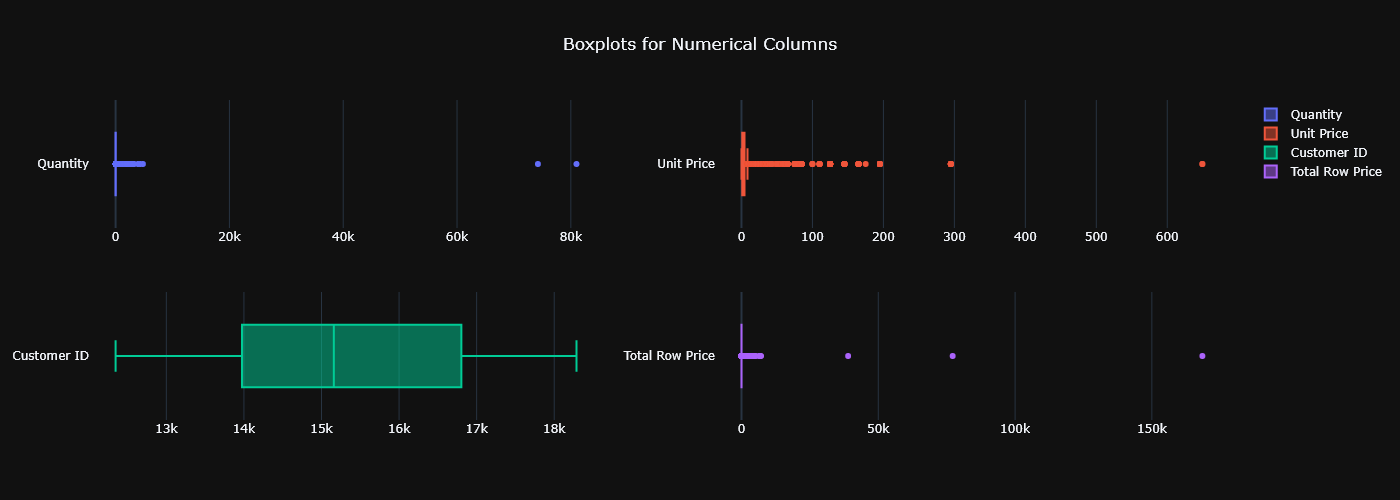

In [ ]:
#Create a dictionary to make plotly graph generation more efficient
array_dicts = {}
for col in df.columns.to_list():
    array_dicts[col] = np.array(df[col])
    
#Create some boxplots to see how our values are distributed
fig = subplots.make_subplots(rows=2, cols=2, vertical_spacing=0.2)

hist1 = go.Box(x=array_dicts['Quantity'], name='Quantity')
hist2 = go.Box(x=array_dicts['UnitPrice'], name ='Unit Price')
hist3 = go.Box(x=array_dicts['CustomerID'], name='Customer ID')
hist4 = go.Box(x=array_dicts['TotalPrice'], name='Total Row Price')

fig.append_trace(hist1, 1,1)
fig.append_trace(hist2, 1,2)
fig.append_trace(hist3, 2,1)
fig.append_trace(hist4, 2,2)

fig.update_layout(title = 'Boxplots for Numerical Columns', title_x = 0.5, width=1400)
#pio.write_image(fig, 'notebook referenced files/boxplot_num.png')

Image('notebook referenced files/boxplot_num.png')

In [6]:
top_percentile = stats_df.loc['99%', :]
top_percentile_reset = stats_df.loc['99%', :].reset_index()
display_side_by_side(top_percentile)

for col in top_percentile_reset['index'].to_list():
    value = float(top_percentile[col])
    print(f"Number of rows higher than {value} for {col} = {len(df[df[col] > value])}")


,99%
Quantity,100.00
UnitPrice,16.63
CustomerID,18212.00
TotalPrice,179.00


Number of rows higher than 100.0 for Quantity = 4842
Number of rows higher than 16.63 for UnitPrice = 4752
Number of rows higher than 18212.0 for CustomerID = 3930
Number of rows higher than 179.0 for TotalPrice = 5073


**Outlier Analysis**

- As we can see from above, we have a significant amount of outliers for 3 out of the 4 columns. This will make it hard for us to interpret histogram plots which is why we decided to filter these out just for this single visualization.

- We can also see that if we used the values that correspond to the top 1 percentile in each column as a cutoff, at worst we would only be discarding around 15,000 out of the 500,000+ rows (only if there is no overlap between the outlier rows, which is unlikely) which is acceptable for the purpose of getting a better visual on the density distributions of these numerical columns

---
#### 1.2. Datetime Feature Engineering

To analyze sales trends over time, we need to extract time-based features from the `InvoiceDate` column. We will engineer `InvoiceMonth` and `InvoiceHour` to enable analysis of monthly and daily sales patterns. The final, enriched DataFrame is then saved in the efficient `.parquet` format for future use.


In [10]:
df['InvoiceDate'] = pd.to_datetime(df["InvoiceDate"])

df['InvoiceDay'] = df['InvoiceDate'].dt.date
df['InvoiceHour'] = df['InvoiceDate'].dt.hour
df['InvoiceHour'] = df['InvoiceHour'].astype(int)
df['InvoiceDay']= pd.to_datetime(df['InvoiceDay'])
df['InvoiceMonth'] = df['InvoiceDate'].dt.month

#Make a str version of our Customer IDs column for indexing purposes
df['CustomerID_str'] = df['CustomerID'].astype(str)
df['CustomerID_str'] = df['CustomerID_str'].str.replace('.0', '')
#df['CustomerID_str'] = df['CustomerID_str'].astype(str)

#Let's save our file as a parquet to save some space
df.to_parquet('online_sales_pos_stock.parquet')
df = pd.read_parquet('online_sales_pos_stock.parquet')

### 2. Visualizing Data Distributions

The following histograms visualize the distributions of our key numerical features, excluding the top 1% of outliers for clarity. This gives us a much better view of the "typical" transaction:

-   **Quantity:** Most transactions involve a small number of items (typically 1-10).
-   **Price:** The majority of items are priced under £5.
-   **Total Price:** Most individual line items are under £20.

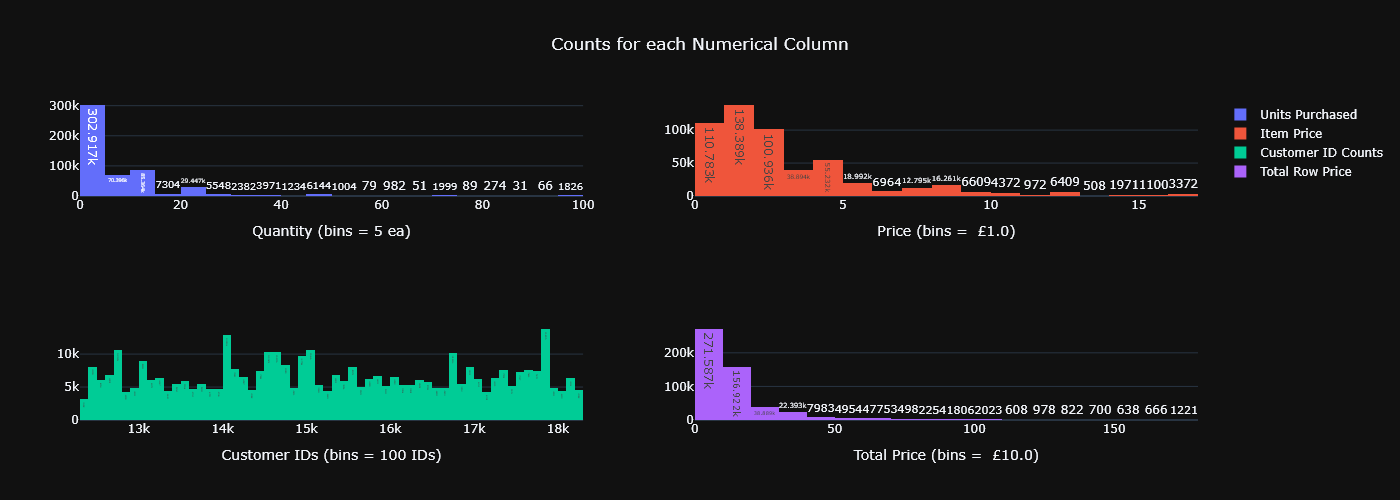

In [8]:
fig = subplots.make_subplots(rows=2, cols=2, vertical_spacing=0.4)

hist1 = go.Histogram(x=array_dicts['Quantity'], texttemplate='%{y}',  xbins=dict(start=0, end = float(top_percentile['Quantity']), size=5), name='Units Purchased')
hist2 = go.Histogram(x=array_dicts['UnitPrice'], texttemplate='%{y}',  xbins=dict(start=0, end = float(top_percentile['UnitPrice']), size=1), name='Item Price')
hist3 = go.Histogram(x=array_dicts['CustomerID'], texttemplate='%{y}', xbins=dict(size=100), name='Customer ID Counts')
hist4 = go.Histogram(x=array_dicts['TotalPrice'],  texttemplate='%{y}',  xbins=dict(start=0, end = float(top_percentile['TotalPrice']), size=10), name='Total Row Price')

# Update x-axis labels
fig.update_xaxes(title_text=  'Quantity (bins = 5 ea)', row=1, col=1)
fig.update_xaxes(title_text='Price (bins = 	£1.0)', row=1, col=2)
fig.update_xaxes(title_text=f'Customer IDs (bins = 100 IDs)', row=2, col=1)
fig.update_xaxes(title_text=f'Total Price (bins = 	£10.0)', row=2, col=2)

fig.append_trace(hist1, 1,1)
fig.append_trace(hist2, 1,2)
fig.append_trace(hist3, 2,1)
fig.append_trace(hist4, 2,2)

fig.update_layout(title = 'Counts for each Numerical Column', title_x = 0.5, width =1400, height =600)
#pio.write_image(fig, 'notebook referenced files/hist1.png')

Image('notebook referenced files/hist1.png')

### 3. Sales Trend Analysis

Now we can leverage the timeseries features we engineered in the section above to create monthly and hourly aggregate views of our data.
#### 3.1. Monthly Sales Trends

The bar chart below shows the total sales revenue for each month in the dataset. This visualization allows us to quickly identify any seasonality in the business.


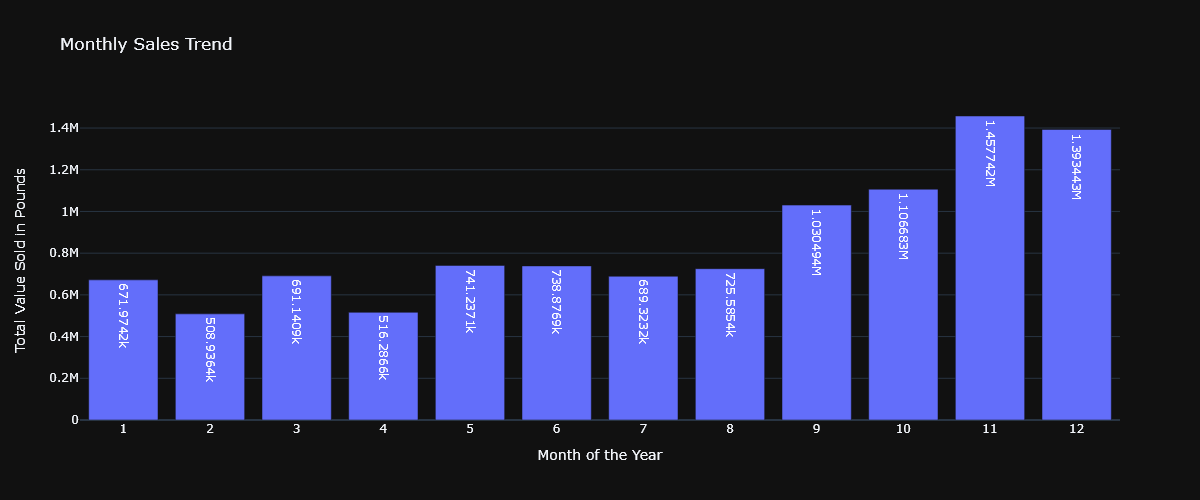

In [ ]:
#Turn month and hour columns into discrete ordinal variables
#We convert these columns at this point to avoid an error that occurs when saved as a parquet file


monthly_totals = df[['InvoiceMonth', 'TotalPrice']].groupby('InvoiceMonth').sum()
monthly_totals = monthly_totals.reset_index()
monthly_totals['InvoiceMonth'] = monthly_totals['InvoiceMonth'].astype(str)
monthly_totals['InvoiceMonth'].to_list()

hourly_totals = df[['InvoiceHour', 'TotalPrice']].groupby('InvoiceHour').sum()
hourly_totals = hourly_totals.reset_index()
hourly_totals['InvoiceHour'] = hourly_totals['InvoiceHour'].astype(str)

fig = go.Figure()
fig.add_trace(go.Bar(x = monthly_totals['InvoiceMonth'], y=np.array(monthly_totals['TotalPrice']), texttemplate='%{y}'))
fig.update_xaxes(title_text='Month of the Year')
fig.update_yaxes(title_text='Total Value Sold in Pounds')
fig.update_layout(title = 'Monthly Sales Trend',xaxis=dict(tickmode='array', dtick = 1), height = 500, width = 1200)
#fig.show()
#pio.write_image(fig, 'notebook referenced files/monthly.png')

Image('notebook referenced files/monthly.png')

**Analysis of Monthly Trends:**

The chart reveals a clear and strong seasonal pattern. There is a significant ramp-up in sales starting in September and peaking dramatically in November, which directly corresponds to the holiday shopping season, ultimately ending the year with an equally impressive December. This seasonality is a critical feature of most businesses, with most general retail businesses following a similar pattern as above.

---
#### 3.2. Hourly Sales Trends

This bar chart visualizes the total sales revenue for each hour of the day (in a 24-hour format). This helps us understand the company's peak operating hours.

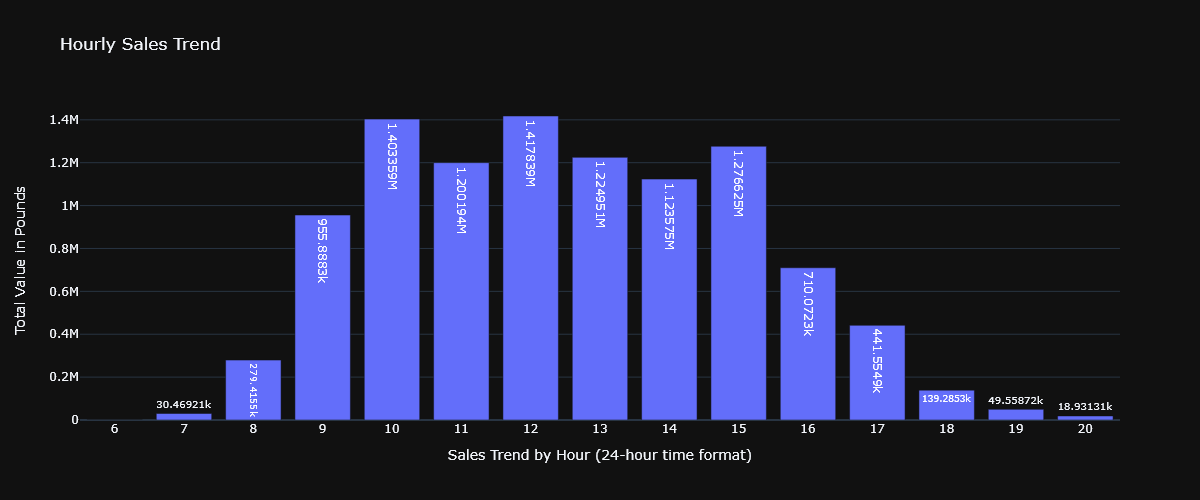

In [17]:

fig2 = go.Figure()
fig2.add_trace(go.Bar(x = hourly_totals['InvoiceHour'], y=np.array(hourly_totals['TotalPrice']), texttemplate='%{y}'))
fig2.update_xaxes(title_text='Sales Trend by Hour (24-hour time format)')
fig2.update_yaxes(title_text='Total Value in Pounds')
fig2.update_layout(title = 'Hourly Sales Trend', xaxis=dict(tickmode='array', dtick = 1),height = 500, width = 1200)
#pio.write_image(fig2, 'hourly.png')

Image('notebook referenced files/hourly.png')

**Analysis of Hourly Trends:**

Sales follow a standard retail day pattern, beginning around 7 AM and peaking between 12 PM and 3 PM. This confirms that the business operates primarily during standard UK business hours.

---
### 4. Customer and Geographic Analysis

#### 4.1. Identifying High-Value Customers (Pareto Analysis)

We now shift our focus to identifying the most valuable customers. According to the Pareto Principle (the 80/20 rule), a large portion of a company's revenue often comes from a small percentage of its customers. The code below identifies the top 20 customers and calculates their total contribution to sales.

In [24]:
#Identify top accounts based on Sales Totals
customers_df = df[~df['CustomerID'].isna()]
total_customers = len(np.unique(df["CustomerID_str"]))
top_accounts = customers_df[['CustomerID_str', 'TotalPrice']].groupby('CustomerID_str').sum()
top_accounts = top_accounts.sort_values(by='TotalPrice', ascending=False)
top_accounts = top_accounts.reset_index()
top_20_accounts = top_accounts[:20]
top_accounts_list = top_accounts[:20]['CustomerID_str'].to_list()
top_20_accounts

#Calculate percent of sales of top 50 accounts
top_accounts_percent = np.sum(top_accounts[:20]['TotalPrice'])/np.sum(df['TotalPrice'])
print(f'The Top 20 Customers generate {top_accounts_percent:.2%} of total sales while only making up 20/{total_customers} = {20/total_customers:.2%} of the entire population.')

#Get all the transactions of the top accounts grouped by Stock Code to find most popular items
top_accounts_transactions = df[df['CustomerID_str'].isin(top_accounts_list)]
top_grouped_by_stock = top_accounts_transactions[['CustomerID_str', 'StockCode', 'TotalPrice']].groupby(['CustomerID_str', 'StockCode']).sum()
top_grouped_stock_reset = top_grouped_by_stock.reset_index()


The Top 20 Customers generate 20.40% of total sales while only making up 20/4335 = 0.46% of the entire population.


**Pareto Analysis Results:**

The analysis confirms the Pareto Principle is in effect: less than a percent of customers account for over 28% of the company's total sales. This highlights the critical importance of extracting all the insights we could gain from our data with regards to customer purchasing behavior as this is what establishes a relationship between customers and businesses. In turn, being more informed about this dynamic can not only help increase the success of retaining these high performing accounts but also possibly generate new ones as well.   

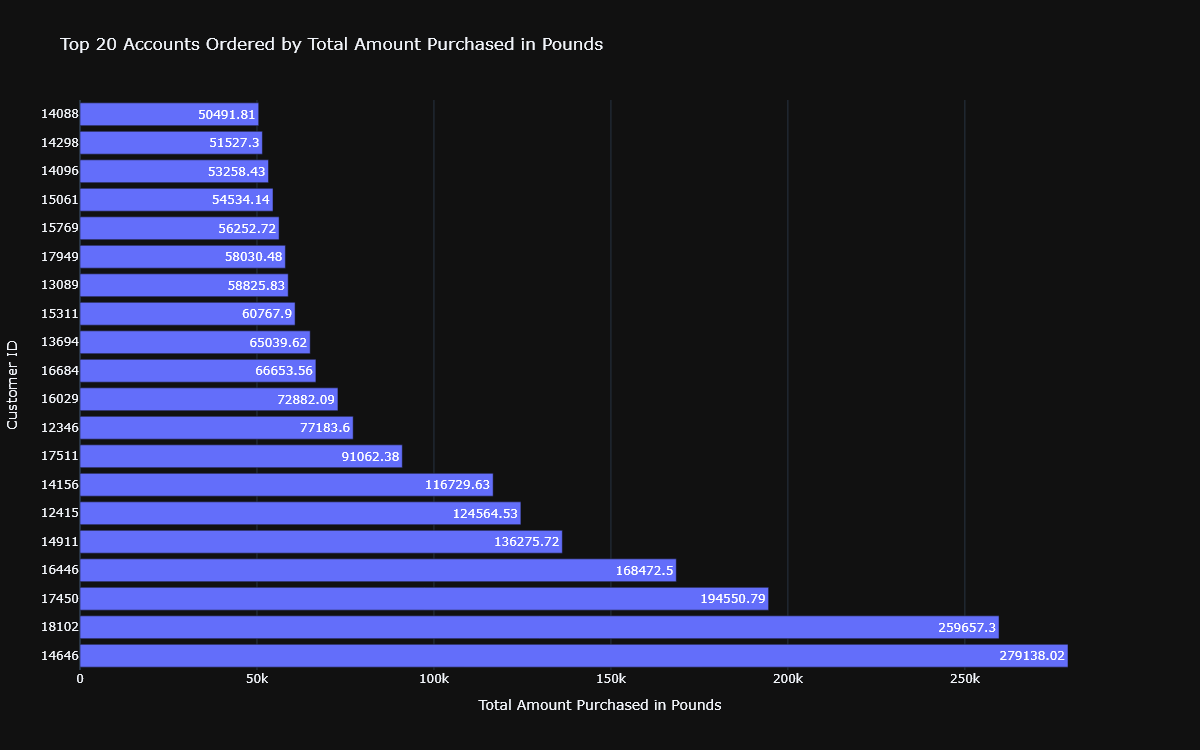

In [25]:
#Let's display the total purchased amounts of each of the top 20 accounts
fig = px.bar(orientation='h', x=top_20_accounts['TotalPrice'], y=top_20_accounts['CustomerID_str'].astype(str),  title='Top 20 Accounts Ordered by Total Amount Purchased in Pounds', text = top_20_accounts['TotalPrice'])
fig.update_layout(xaxis_title='Total Amount Purchased in Pounds', yaxis_title='Customer ID', height = 750, width = 1200)
pio.write_image(fig, 'notebook referenced files/top_20.png')

Image('notebook referenced files/top_20.png')

#### 4.2. Visualizing Top Customer Purchasing Habits

To gain some insight on customer purchashing behavior, we start by trying to understand *what* they buy. The stacked bar chart below shows the purchasing composition for the top 20 accounts, broken down by the individual `StockCode`.

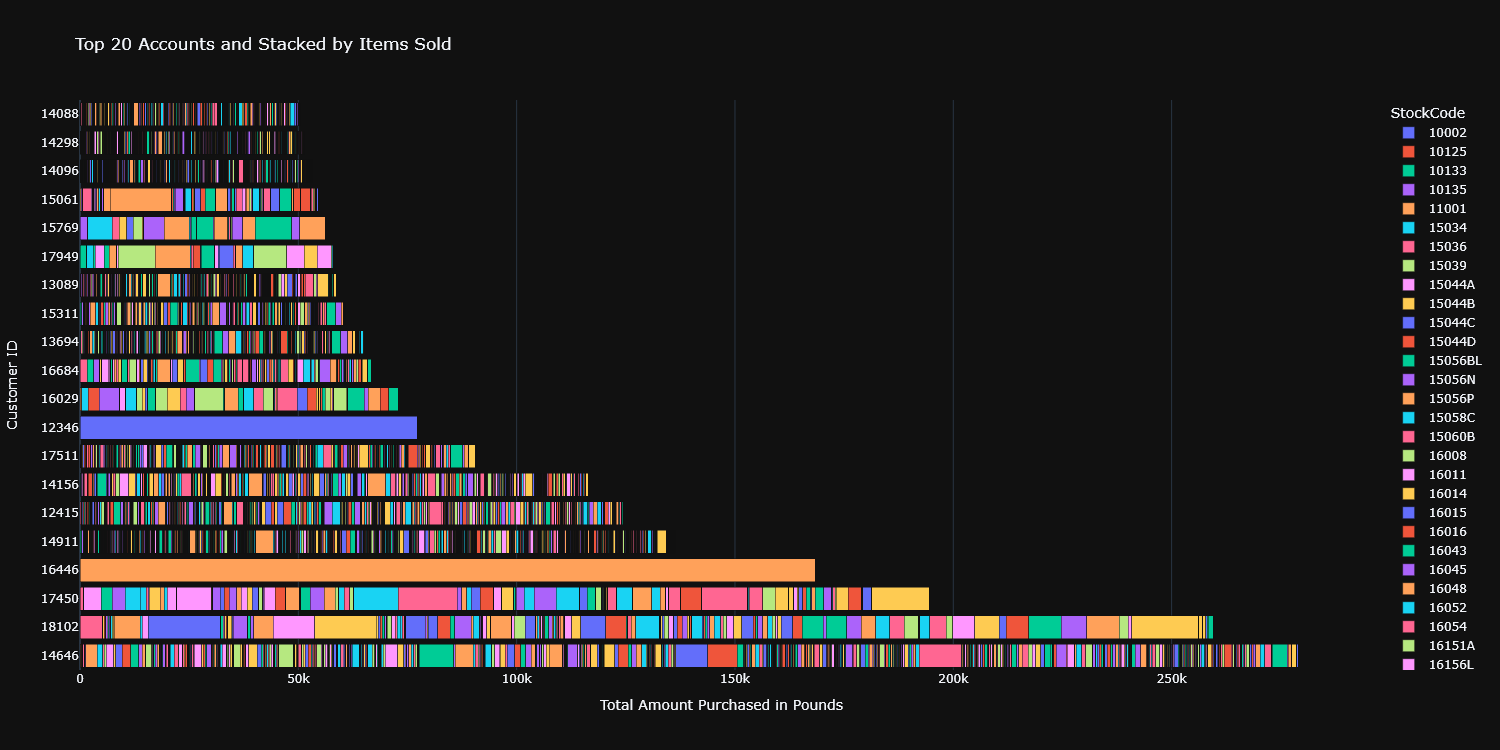

In [ ]:
#Create a dictionary to sort values based on amounts purchased for the top accounts
top_accounts_sorting = {}
for i in range (0, len(top_accounts_list)):
    top_accounts_sorting[top_accounts_list[i]] = i

#Groupe data by Customer IDs first and Stock Codes second, while 
#Sum up the total amounts purchased
#Then pivot the dataframe for our stacked bar chart
top_grouped_stock_reset = top_accounts_transactions[['CustomerID_str', 'StockCode', 'TotalPrice']].groupby(['CustomerID_str', 'StockCode']).sum().reset_index()
top_grouped_stock_reset = top_grouped_stock_reset.sort_values( by= 'CustomerID_str', key=lambda x:x.map(top_accounts_sorting))

pivot_df = top_grouped_stock_reset.pivot(index='CustomerID_str', columns='StockCode', values='TotalPrice').fillna(0)
pivot_df = pivot_df.sort_index(level = 1, key=lambda x:x.map(top_accounts_sorting))

#Plotting our stacked bar chart
fig = px.bar(pivot_df, orientation='h', title='Top 20 Accounts and Stacked by Items Sold')
fig.update_layout(barmode='stack', xaxis_title='Total Amount Purchased in Pounds', yaxis_title='Customer ID', height=750, width = 1500)
#pio.write_image(fig, 'notebook referenced files/top_accounts_with_items_purchased.png')

Image('notebook referenced files/top_accounts_with_items_purchased.png')

**Analysis of Purchasing Habits:**

The visualization reveals diverse purchasing behaviors even among top customers:

-   **Broad Range:** Most high-value customers purchase a wide variety of items.
-   **Specialized Wholesalers:** A few accounts are notable for purchasing massive quantities of a single `StockCode`, indicating they are likely specialized wholesalers.

This initial view is insightful but also noisy due to the thousands of unique `StockCodes`. This provides a strong business justification for the product categorization through machine learning that will be performed in the next notebook.

### 5. Geographic Sales Distribution

To understand the company's market reach, we will create a choropleth map visualizing the total number of orders by country.

#### 5.1. Data Preparation for Mapping

The `country_converter` library is used to convert country names to the standard ISO-3 format required for plotting. A log transformation is applied to the order counts to better visualize the variation between countries with vastly different order volumes.

In [ ]:
#For now let's visualize the countries from where our orders come from
countries_df = pd.DataFrame(df['Country'].value_counts().reset_index())

# Convert country names to ISO 3-letter codes
import country_converter as coco
countries_df['ISO'] = coco.convert(names=countries_df['Country'], to='ISO3')
display_side_by_side(countries_df[countries_df['ISO'] == 'not found'])

#Replace some of the country names to something that can be used with country converter, manually change Channel Islands ISO code
countries_df['Country'] = countries_df['Country'].replace({'EIRE':'Ireland', 'RSA':'South Africa'})
countries_df['ISO'] = coco.convert(names=countries_df['Country'], to='ISO3')
countries_df.at[11, 'ISO'] = 'GB-CHA'

#Filter out Countries that are not specific/unspecified
countries_to_remove = ['Unspecified', 'European Community']
countries_df_filtered = countries_df[~countries_df['Country'].isin(countries_to_remove)]



EIRE not found in regex
Channel Islands not found in regex
Unspecified not found in regex
European Community not found in regex
RSA not found in ISO3


,Country,count,ISO
3,EIRE,7779,not found
11,Channel Islands,744,not found
15,Unspecified,446,not found
30,European Community,57,not found
31,RSA,57,not found


Channel Islands not found in regex
Unspecified not found in regex
European Community not found in regex


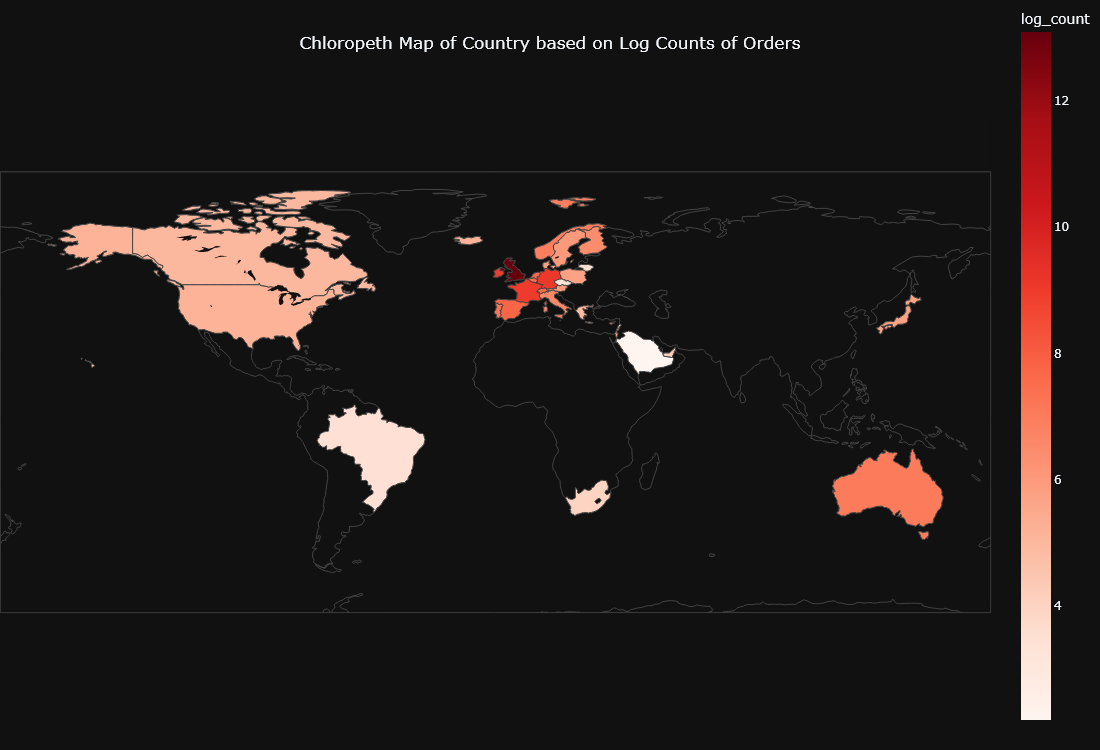

In [24]:
#Convert count to log_counts to see better gradiation in Chloropeth map
countries_df_filtered['log_count'] = np.log(countries_df_filtered['count'])

# Load GeoJSON data
with urlopen('https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json') as response:
    countries = json.load(response)


# Create the choropleth map
fig = px.choropleth(countries_df_filtered, geojson=countries, locations='ISO', color='log_count', color_continuous_scale='reds', labels='count')
fig.update_geos(fitbounds="locations")
fig.update_layout(title= 'Chloropeth Map of Country based on Log Counts of Orders', title_x = 0.5, title_y = 0.95, margin={"r":0,"t":0,"l":0,"b":20}, height=750, width = 1100)
pio.write_image(fig, 'chloropeth.png')

Image('chloropeth.png')


**Analysis of Geographic Distribution:**

As expected, the vast majority of orders originate from the United Kingdom. However, the company has a significant presence in Western Europe (especially Ireland, Germany, France, and the Netherlands) and a notable global reach, with orders coming from major economies like the USA, Canada, and Australia. This indicates a healthy mix of domestic and international business.